In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from nltk.corpus import stopwords
import re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\icono\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Credit Status Dataset

## All features in a list with convenient type of data to use:
### Categorical
* <span style="color:red">ID</span>
* <span style="color:red">Customer_ID</span>
* Month (Can be converted to number or kept like this)
* <span style="color:red">Name</span>
* <span style="color:red">SSN</span>
* Occupation
* Type of Loan
* Credit_mix
* Payment behaviour
* Payment_of_min_amount

### Discrete
* Age
* Num_Bank_Accounts
* Interest Rate (Interest rate of loan)
* Num of Loan
* Delay_from_due_date
* Num_of_delayed_payment
* Num_Credit_Card	

### Continous
* Annual_Income
* Monthly_Inhand Salary
* Monthly_Balance
* Credit history age

We need a rule that can determine whether someone receives a credit or not, let's consider the following:
* Regular incomes.
* Enough payment capacity.
* Debt Ratio (Ratio de endeudamiento).
* Límite de capacidad de endeudamiento (Ingresos mensuales-Gastos Fijos) x0,40
* Number of bank accounts(More than 3 will be considered a risk)
* For discriminatory reasons, We won't consider ocuppation as a risk, we will focus more on other attributes.
* We will consider annual income divided by 12 instead of the monthly inhand salary, mainly because monthly inhand salary has a lot of missing values.It is relevant to consider annual income doesn't come with the same information that monthly inhand salary comes with.
* For the model, the Name won't matter to us as the number of loans already is enough to tell if someone should receive a credit or not.
* Interest rate can be relevant, however this does not determine whether someone gets a credit or not.
* The month 
* Nos hace falta 
#### Removing:
* ID
* Customer_ID
* Month
* Name
* Occupation
* Monthly Inhand Salary
* Interest Rate

We are missing the amount of loan that was asked.
The time needed for the payment to be concluded.

##### Here we insert pending rule function

#### Data Exploration, Data Cleaning and Data Preprocessing

##### Numeric data cleaning

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/mau-JS/OracleML/main/credit-status-dataset.csv')
df['Target'] = -1
df.head()

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,target
0,0x160a,CUS_0xd40,September,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,Good,22 Years and 9 Months,No,Low_spent_Small_value_payments,186.2667021,-1
1,0x160b,CUS_0xd40,October,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,9,Good,22 Years and 10 Months,No,High_spent_Medium_value_payments,361.4440039,-1
2,0x160c,CUS_0xd40,November,Aaron Maashoh,24,821-00-0265,Scientist,19114.12,1824.843333,3,...,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,4,Good,NaN,No,Low_spent_Medium_value_payments,264.6754462,-1
3,0x160d,CUS_0xd40,December,Aaron Maashoh,24_,821-00-0265,Scientist,19114.12,NaN,3,...,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4,5,Good,23 Years and 0 Months,No,High_spent_Medium_value_payments,343.8268732,-1
4,0x1616,CUS_0x21b1,September,Rick Rothackerj,28,004-07-5839,_______,34847.84,3037.986667,2,...,1,Credit-Builder Loan,3,1,Good,27 Years and 3 Months,No,High_spent_Large_value_payments,485.2984337,-1


In [3]:
#For consistency and relevance, we convert years and months to continous values. Our years will be kept as discrete values and months as decimals.
def convert_to_years(s):
    years, months = 0, 0
    if isinstance(s, str):
        parts = s.split('and')
        if 'Year' in parts[0]:
            years = int(parts[0].split(' Year')[0])
        if len(parts) > 1 and 'Month' in parts[1]:
            months = int(parts[1].split(' Month')[0])
    return years + months / 12.0

df['Credit_History_Age'] = df['Credit_History_Age'].apply(convert_to_years)

In [4]:
#We remove irrelevant and sensitive data
df = df.drop(['ID','Customer_ID','Name','SSN','Month','Occupation','Monthly_Inhand_Salary','Interest_Rate'],axis=1)
df.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,target
0,September,23,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7,Good,22.750000,No,Low_spent_Small_value_payments,186.2667021,-1
1,October,24,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,9,Good,22.833333,No,High_spent_Medium_value_payments,361.4440039,-1
2,November,24,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,4,Good,0.000000,No,Low_spent_Medium_value_payments,264.6754462,-1
3,December,24_,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4,5,Good,23.000000,No,High_spent_Medium_value_payments,343.8268732,-1
4,September,28,_______,34847.84,3037.986667,2,4,6,1,Credit-Builder Loan,3,1,Good,27.250000,No,High_spent_Large_value_payments,485.2984337,-1


In [5]:
#This will help us notice what columns are numeric or not. This can tell us if we have to convert the data to other format or apply data cleaning.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Monthly_Inhand_Salary,42502.0,4182.004291,3174.109304,303.645417,1625.188333,3086.305000,5934.189094,15204.63333
Num_Bank_Accounts,50000.0,16.838260,116.396848,-1.000000,3.000000,6.000000,7.000000,1798.00000
Num_Credit_Card,50000.0,22.921480,129.314804,0.000000,4.000000,5.000000,7.000000,1499.00000
Interest_Rate,50000.0,68.772640,451.602363,1.000000,8.000000,13.000000,20.000000,5799.00000
Delay_from_due_date,50000.0,21.052640,14.860397,-5.000000,10.000000,18.000000,28.000000,67.00000
Credit_History_Age,50000.0,17.244577,9.584866,0.000000,10.083333,17.916667,24.833333,34.00000
target,50000.0,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000


Removing unknown symbols from Age and converting to numeric data

In [6]:
# Replacing non-numeric characters with an empty string
df['Age'] = df['Age'].str.replace(r'\D', '', regex=True)
# Convert the 'Age' column to a numeric type
df['Age'] = pd.to_numeric(df['Age'])

In [7]:
#Now age is with the proper format and with non numeric symbols removed.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,50000.0,118.994420,678.133254,14.000000,25.000000,34.000000,43.000000,8688.00000
Monthly_Inhand_Salary,42502.0,4182.004291,3174.109304,303.645417,1625.188333,3086.305000,5934.189094,15204.63333
Num_Bank_Accounts,50000.0,16.838260,116.396848,-1.000000,3.000000,6.000000,7.000000,1798.00000
Num_Credit_Card,50000.0,22.921480,129.314804,0.000000,4.000000,5.000000,7.000000,1499.00000
Interest_Rate,50000.0,68.772640,451.602363,1.000000,8.000000,13.000000,20.000000,5799.00000
Delay_from_due_date,50000.0,21.052640,14.860397,-5.000000,10.000000,18.000000,28.000000,67.00000
Credit_History_Age,50000.0,17.244577,9.584866,0.000000,10.083333,17.916667,24.833333,34.00000
target,50000.0,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000


In [8]:
#There seems to be possible duplicates for Customer_ID, we must keep those that can be considered as a different transaction but should remove those
#that have same values.
#Removing duplicates where all transaction data is the same, yet ID is different. This allows us to prevent the user from spamming requests of credit.
cols = [col for col in df.columns if col != 'ID']

# Drop duplicates considering only the subset of columns
df = df.drop_duplicates(subset=cols)

#We drop duplicates where all values are the same.
df = df.drop_duplicates()
#This time there were no rows removed, however this data cleaning can be relevant if the dataset grows more.

We check if values that should be numerical, are really numerical.

In [9]:
#Looking at type of value.
print(df['Annual_Income'].dtypes)
#This prints "object" which means there are non numeric values.
#We convert all values to numeric.
df['Annual_Income'] = pd.to_numeric(df['Annual_Income'], errors='coerce')
#We print again to verify all values are numbers.
print(df['Annual_Income'].dtypes)

object
float64


We check again our dataset with describe.

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,50000.0,118.994420,6.781333e+02,14.000000,25.000000,34.000000,43.000000,8.688000e+03
Annual_Income,46480.0,165116.921762,1.341967e+06,7005.930000,19435.600000,37575.870000,72760.040000,2.413726e+07
Monthly_Inhand_Salary,42502.0,4182.004291,3.174109e+03,303.645417,1625.188333,3086.305000,5934.189094,1.520463e+04
Num_Bank_Accounts,50000.0,16.838260,1.163968e+02,-1.000000,3.000000,6.000000,7.000000,1.798000e+03
Num_Credit_Card,50000.0,22.921480,1.293148e+02,0.000000,4.000000,5.000000,7.000000,1.499000e+03
Interest_Rate,50000.0,68.772640,4.516024e+02,1.000000,8.000000,13.000000,20.000000,5.799000e+03
Delay_from_due_date,50000.0,21.052640,1.486040e+01,-5.000000,10.000000,18.000000,28.000000,6.700000e+01
Credit_History_Age,50000.0,17.244577,9.584866e+00,0.000000,10.083333,17.916667,24.833333,3.400000e+01
target,50000.0,-1.000000,0.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00


We notice Num_of_Loan does not appear, so we have to convert it and clean it if needed.

In [11]:
# Replacing non-numeric characters with an empty string
df['Num_of_Loan'] = df['Num_of_Loan'].str.replace(r'\D', '', regex=True)
# Convert the 'Age' column to a numeric type
df['Num_of_Loan'] = pd.to_numeric(df['Num_of_Loan'])
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,50000.0,118.994420,6.781333e+02,14.000000,25.000000,34.000000,43.000000,8.688000e+03
Annual_Income,46480.0,165116.921762,1.341967e+06,7005.930000,19435.600000,37575.870000,72760.040000,2.413726e+07
Monthly_Inhand_Salary,42502.0,4182.004291,3.174109e+03,303.645417,1625.188333,3086.305000,5934.189094,1.520463e+04
Num_Bank_Accounts,50000.0,16.838260,1.163968e+02,-1.000000,3.000000,6.000000,7.000000,1.798000e+03
Num_Credit_Card,50000.0,22.921480,1.293148e+02,0.000000,4.000000,5.000000,7.000000,1.499000e+03
Interest_Rate,50000.0,68.772640,4.516024e+02,1.000000,8.000000,13.000000,20.000000,5.799000e+03
Num_of_Loan,50000.0,11.299360,6.548350e+01,0.000000,2.000000,3.000000,6.000000,1.496000e+03
Delay_from_due_date,50000.0,21.052640,1.486040e+01,-5.000000,10.000000,18.000000,28.000000,6.700000e+01
Credit_History_Age,50000.0,17.244577,9.584866e+00,0.000000,10.083333,17.916667,24.833333,3.400000e+01
target,50000.0,-1.000000,0.000000e+00,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00


Num_of_Delayed_Payment still does not appear as numeric.

In [12]:
# Replacing non-numeric characters with an empty string
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.replace(r'\D', '', regex=True)
# Convert the 'Age' column to a numeric type
df['Num_of_Delayed_Payment'] = pd.to_numeric(df['Num_of_Delayed_Payment'])
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,50000.0,118.994420,6.781333e+02,14.000000,25.000000,34.000000,43.000000,8.688000e+03
Annual_Income,46480.0,165116.921762,1.341967e+06,7005.930000,19435.600000,37575.870000,72760.040000,2.413726e+07
Monthly_Inhand_Salary,42502.0,4182.004291,3.174109e+03,303.645417,1625.188333,3086.305000,5934.189094,1.520463e+04
Num_Bank_Accounts,50000.0,16.838260,1.163968e+02,-1.000000,3.000000,6.000000,7.000000,1.798000e+03
Num_Credit_Card,50000.0,22.921480,1.293148e+02,0.000000,4.000000,5.000000,7.000000,1.499000e+03
Interest_Rate,50000.0,68.772640,4.516024e+02,1.000000,8.000000,13.000000,20.000000,5.799000e+03
Num_of_Loan,50000.0,11.299360,6.548350e+01,0.000000,2.000000,3.000000,6.000000,1.496000e+03
Delay_from_due_date,50000.0,21.052640,1.486040e+01,-5.000000,10.000000,18.000000,28.000000,6.700000e+01
Num_of_Delayed_Payment,46502.0,30.910369,2.215075e+02,0.000000,9.000000,14.000000,18.000000,4.399000e+03
Credit_History_Age,50000.0,17.244577,9.584866e+00,0.000000,10.083333,17.916667,24.833333,3.400000e+01


Monthly Balance does not appear as numeric.

In [13]:
# Replacing non-numeric characters with an empty string
#11363
#print(df.iloc[11363])
df['Monthly_Balance'] = df['Monthly_Balance'].str.replace(r'\D', '', regex=True)
#We convert to float as there are numbers that int can't handle.
df['Monthly_Balance'] = pd.to_numeric(df['Monthly_Balance'], errors='coerce', downcast='float')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,50000.0,1.189944e+02,6.781333e+02,14.000000,2.500000e+01,3.400000e+01,4.300000e+01,8.688000e+03
Annual_Income,46480.0,1.651169e+05,1.341967e+06,7005.930000,1.943560e+04,3.757587e+04,7.276004e+04,2.413726e+07
Monthly_Inhand_Salary,42502.0,4.182004e+03,3.174109e+03,303.645417,1.625188e+03,3.086305e+03,5.934189e+03,1.520463e+04
Num_Bank_Accounts,50000.0,1.683826e+01,1.163968e+02,-1.000000,3.000000e+00,6.000000e+00,7.000000e+00,1.798000e+03
Num_Credit_Card,50000.0,2.292148e+01,1.293148e+02,0.000000,4.000000e+00,5.000000e+00,7.000000e+00,1.499000e+03
Interest_Rate,50000.0,6.877264e+01,4.516024e+02,1.000000,8.000000e+00,1.300000e+01,2.000000e+01,5.799000e+03
Num_of_Loan,50000.0,1.129936e+01,6.548350e+01,0.000000,2.000000e+00,3.000000e+00,6.000000e+00,1.496000e+03
Delay_from_due_date,50000.0,2.105264e+01,1.486040e+01,-5.000000,1.000000e+01,1.800000e+01,2.800000e+01,6.700000e+01
Num_of_Delayed_Payment,46502.0,3.091037e+01,2.215075e+02,0.000000,9.000000e+00,1.400000e+01,1.800000e+01,4.399000e+03
Credit_History_Age,50000.0,1.724458e+01,9.584866e+00,0.000000,1.008333e+01,1.791667e+01,2.483333e+01,3.400000e+01


##### Categorical Data Cleaning

In the ‘Occupation’ column, some rows contain symbols instead of an occupation name. These symbols are placeholders indicating that the occupation is not specified. However, to maintain consistency and clarity in our data, it’s better to represent these unspecified values with 'None'.

In [14]:
# Replace non-letter entries with None
df.loc[df['Occupation'].str.isalpha() == False, 'Occupation'] = 'Unknown'

In [15]:
#Looking at clean dataset
df.head()

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Credit_Mix,Credit_History_Age,Payment_of_Min_Amount,Payment_Behaviour,Monthly_Balance,target
0,September,23,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,7.0,Good,22.750000,No,Low_spent_Small_value_payments,1.862667e+09,-1
1,October,24,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",3,9.0,Good,22.833333,No,High_spent_Medium_value_payments,3.614440e+09,-1
2,November,24,Scientist,19114.12,1824.843333,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",-1,4.0,Good,0.000000,No,Low_spent_Medium_value_payments,2.646754e+09,-1
3,December,24,Scientist,19114.12,NaN,3,4,3,4,"Auto Loan, Credit-Builder Loan, Personal Loan,...",4,5.0,Good,23.000000,No,High_spent_Medium_value_payments,3.438269e+09,-1
4,September,28,Unknown,34847.84,3037.986667,2,4,6,1,Credit-Builder Loan,3,1.0,Good,27.250000,No,High_spent_Large_value_payments,4.852984e+09,-1


Handling types of loans, as they come with multivalues. Handling missing data of column with imputation of default value 'Not Specified'

In [16]:
 # Define the loan types you're interested in
loan_types = ['Auto Loan', 'Credit-Builder Loan', 'Personal Loan', 'Home Equity Loan',  'Mortgage Loan','Payday Loan','Student Loan','Debt Consolidation Loan','Not Specified','Payday Loan']

# Create a new column for each loan type that counts the number of occurrences
for loan in loan_types:
    df[loan] = df['Type_of_Loan'].apply(lambda x: x.count(loan) if isinstance(x, str) else 0)

# If a row doesn't fall into any of these categories, mark it as 'other'
df['Not Specified'] = df[loan_types].apply(lambda x: 0 if any(x) else 1, axis=1)

# Now you can drop the original 'Type_of_Loan' column
df = df.drop('Type_of_Loan', axis=1)
df 

,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,target,Auto Loan,Credit-Builder Loan,Personal Loan,Home Equity Loan,Mortgage Loan,Payday Loan,Student Loan,Debt Consolidation Loan,Not Specified
0,September,23,Scientist,19114.12,1824.843333,3,4,3,4,3,...,-1,1,1,1,1,0,0,0,0,0
1,October,24,Scientist,19114.12,1824.843333,3,4,3,4,3,...,-1,1,1,1,1,0,0,0,0,0
2,November,24,Scientist,19114.12,1824.843333,3,4,3,4,-1,...,-1,1,1,1,1,0,0,0,0,0
3,December,24,Scientist,19114.12,NaN,3,4,3,4,4,...,-1,1,1,1,1,0,0,0,0,0
4,September,28,Unknown,34847.84,3037.986667,2,4,6,1,3,...,-1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,December,4975,Architect,20002.88,1929.906667,10,8,29,5,33,...,-1,1,0,1,0,1,0,2,0,0
49996,September,25,Mechanic,39628.99,NaN,4,6,7,2,20,...,-1,1,0,0,0,0,0,1,0,0
49997,October,25,Mechanic,39628.99,3359.415833,4,6,7,2,23,...,-1,1,0,0,0,0,0,1,0,0
49998,November,25,Mechanic,39628.99,NaN,4,6,7,2,21,...,-1,1,0,0,0,0,0,1,0,0


Fixing column names so they properly follow a format.

In [17]:
# Define English stopwords
stop_words = set(stopwords.words('english'))

# Define a function to clean column names
def clean_column_name(col_name):
    # Split the column name into words
    words = col_name.split()
    # Remove stopwords and capitalize the first letter of non-stopwords
    cleaned_name = ' '.join(word.title() if word not in stop_words else word for word in words)
    # Replace spaces with underscores
    cleaned_name = re.sub(r'\s+', '_', cleaned_name)
    return cleaned_name

# Apply the function to each column name in the DataFrame
df.columns = [clean_column_name(col) for col in df.columns]

---

##### Handling missing data

Month has 0 missing values
Age has 0 missing values
Occupation has 0 missing values
Annual_Income has 3520 missing values
Monthly_Inhand_Salary has 7498 missing values
Num_Bank_Accounts has 0 missing values
Num_Credit_Card has 0 missing values
Interest_Rate has 0 missing values
Num_Of_Loan has 0 missing values
Delay_From_Due_Date has 0 missing values
Num_Of_Delayed_Payment has 3498 missing values
Credit_Mix has 0 missing values
Credit_History_Age has 0 missing values
Payment_Of_Min_Amount has 0 missing values
Payment_Behaviour has 0 missing values
Monthly_Balance has 562 missing values
Target has 0 missing values
Auto_Loan has 0 missing values
Credit-Builder_Loan has 0 missing values
Personal_Loan has 0 missing values
Home_Equity_Loan has 0 missing values
Mortgage_Loan has 0 missing values
Payday_Loan has 0 missing values
Student_Loan has 0 missing values
Debt_Consolidation_Loan has 0 missing values
Not_Specified has 0 missing values


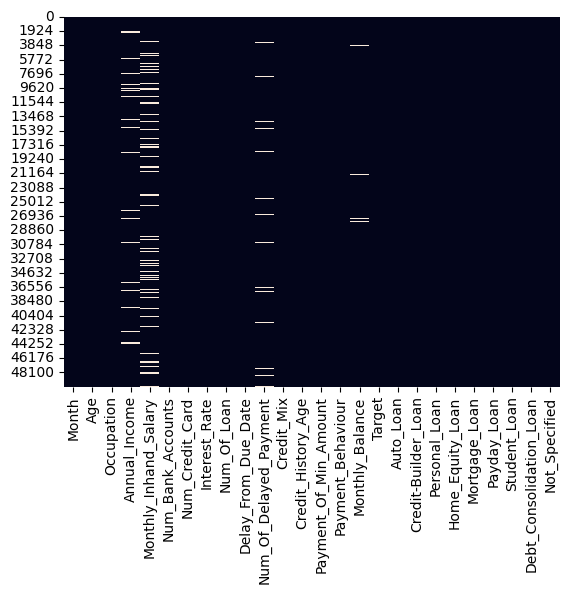

In [18]:
#Visualizing missing data
sns.heatmap(df.isnull(), cbar=False)
# Checking missing values for all attributes
for i in df.columns:
  missing_values = df[i].isna()
  print(f'{i} has {missing_values.sum()} missing values')

In [19]:
  #We can consider removing monthly inhand salary as we already have annual income. Also monthly inhand salary has a lot of missing values.
df = df.drop('Monthly_Inhand_Salary',axis=1)

Annual_Income Column imputation with median. We can't remove this column as it has great impact on user possibilities on getting a credit.

In [20]:
from sklearn.impute import SimpleImputer

# We create an instance of SimpleImputer with median as strategy
imputer = SimpleImputer(strategy='median')

# We apply the imputer to the 'Annual_Income' column and leave it with no missing values.
df['Annual_Income'] = imputer.fit_transform(df['Annual_Income'].values.reshape(-1, 1))

<Axes: >

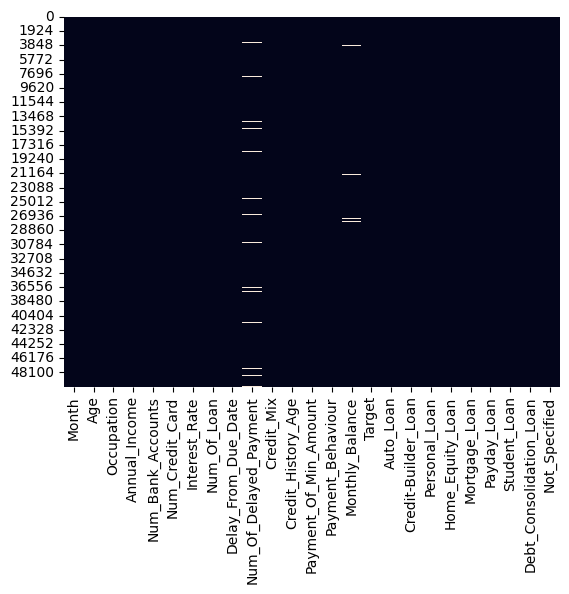

In [21]:
sns.heatmap(df.isnull(), cbar=False)

---

Ordinal Encoding for Credit_Mix, we convert our possible values or turn to NaN any value that is different.

In [22]:
# Define a mapping from category to number
#credit_mix_mapping = {'Bad': 0, 'Standard': 1, 'Good': 2}

# Apply the mapping to the 'Credit_Mix' column
#df['Credit_Mix'] = df['Credit_Mix'].map(credit_mix_mapping)
#df

Converting categorical values to integers

In [23]:
#df['Credit_Mix'] = df['Credit_Mix'].astype(int)
#df['Credit_Mix']

---

#### Looking for outliers

---

#### Chi Square Test

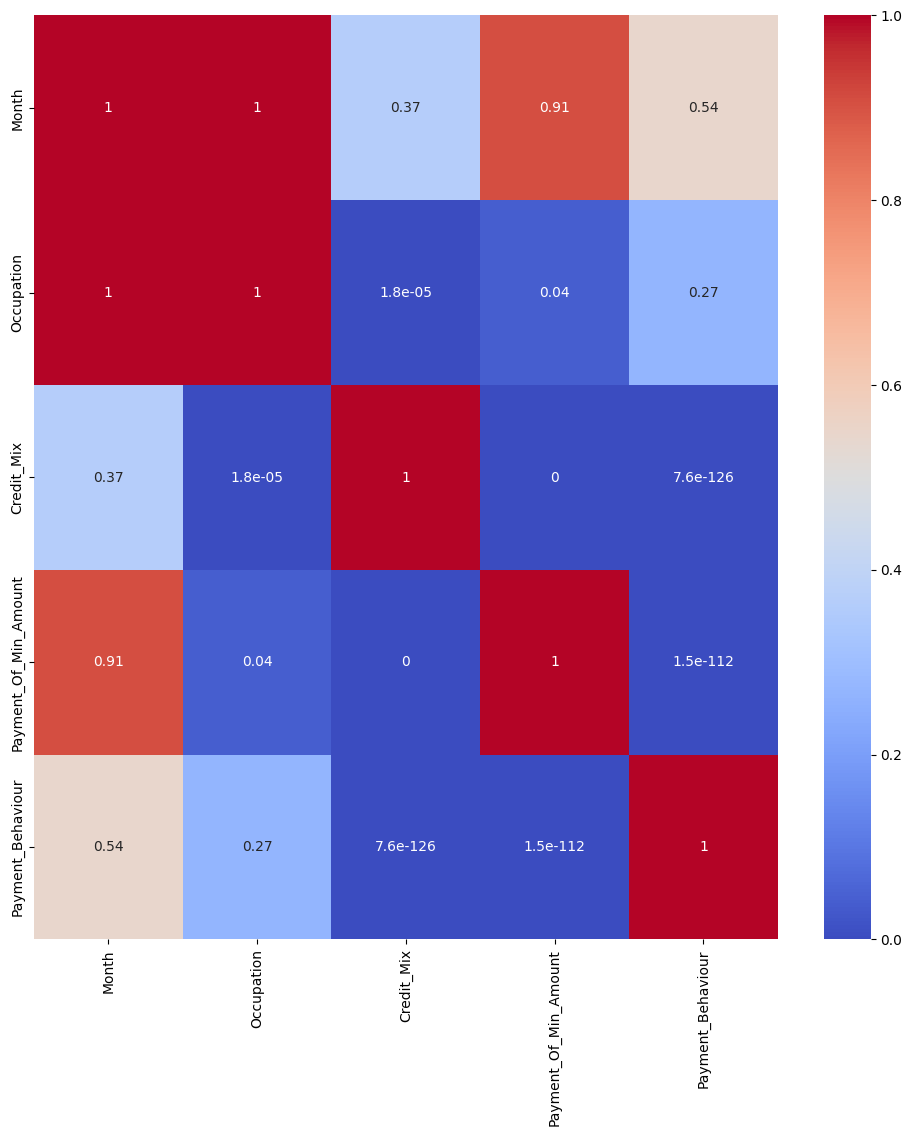

In [24]:
# Get a list of all categorical columns in df
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Initialize a DataFrame to store the p-values
p_values = pd.DataFrame(index=categorical_cols, columns=categorical_cols)

# Loop over each pair of categorical columns and perform Chi-Square test
for i in range(len(categorical_cols)):
    for j in range(i+1, len(categorical_cols)):
        contingency_table = pd.crosstab(df[categorical_cols[i]], df[categorical_cols[j]])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        # Store the p-value in the DataFrame
        p_values.loc[categorical_cols[i], categorical_cols[j]] = p

# Since the matrix is symmetric, copy the upper triangle values to the lower triangle
p_values = p_values.combine_first(p_values.T)

# Replace NaN values with 1 (since p-value for a variable with itself is 1)
p_values.fillna(1, inplace=True)
plt.figure(figsize=(12, 12))
# Plot the heatmap using seaborn
sns.heatmap(p_values.astype(float), cmap='coolwarm', annot=True)
plt.show()

In [25]:
#Here goes the correlation matrix

#### Considering our chi square test, we can determine what values we can remove given their p values. We check whether

In [26]:
#Function that determines whether a client receives a credit or not.
#Example of function that determines credit worthiness
#def determine_creditworthiness(client):
    # Define your conditions for credit approval
#    if (client['Annual_Income'] > 50000) and (client['Credit_History_Age'] > '5 Years') and (client['Num_of_Delayed_Payment'] < 3):
#        return 'Approved'
#    else:
#        return 'Not Approved'